In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# WEATHER PREDICTION

Our dataset uses daily weather measurements from 18 different European cities for which daily observations were available in the years 2000 to 2010.

These were Basel (Switzerland), Budapest (Hungary), Dresden, Düsseldorf, Kassel, and Munich (all in Germany), De Bilt and Maastricht (Netherlands), Heathrow (UK), Ljubljana (Slovenia), Malmo and Stockholm (Sweden), Montélimar, Perpignan, and Tours (France), Oslo (Norway), Rome (Italy), and Sonnblick (Austria).

In [27]:
data = pd.read_csv("./weather_prediction_dataset.csv")
data.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


## CLEANING THE DATA

First we check if there is no missing data or set to null

In [28]:
missing_values = data.isnull().sum()
print("\nValori mancanti per colonna:")
print(missing_values)


Valori mancanti per colonna:
DATE                      0
MONTH                     0
BASEL_cloud_cover         0
BASEL_humidity            0
BASEL_pressure            0
                         ..
TOURS_global_radiation    0
TOURS_precipitation       0
TOURS_temp_mean           0
TOURS_temp_min            0
TOURS_temp_max            0
Length: 165, dtype: int64


And even if there are duplicate data rows

In [29]:
duplicate_values = data.duplicated().sum()
print("\nNumero di righe duplicate:", duplicate_values)


Numero di righe duplicate: 0


For our study, we decided to use data from only one of these cities in the dataset.
We chose Munich because it was the city with the most features in the dataset.

Therefore, we removed all columns related to the other cities and kept those related to Munich and those identifying day and month

In [30]:
columns_to_keep = ['DATE', 'MONTH'] + [col for col in data.columns if 'MUENCHEN' in col.upper()]
df = data[columns_to_keep]

data_copy = df.copy()


# Modify column names
for col in data_copy.columns[2:]:
    new_col_name = col.replace('MUENCHEN_', '')
    data_copy.rename(columns={col: new_col_name}, inplace=True)
df = data_copy

df['rainy_day'] = (df['precipitation'] > 0.05).astype(int)
df['sunny_day'] = (df['sunshine'] > 5).astype(int)
df['good_day'] = ((df['precipitation'] < 0.05) & (df['sunshine'] > 5) & (df['temp_mean'] > 14)).astype(int)
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df['year'] = df['DATE'].dt.year
df['day'] = df['DATE'].dt.day
df['MONTH'] = df['DATE'].dt.month

df.rename(columns={'MONTH': 'month'}, inplace=True)

df.drop('DATE', axis=1, inplace=True)

df = df[['day','month','year'] + [col for col in df.columns if col not in ['year', 'month', 'day']]]

df.head()

,day,month,year,cloud_cover,wind_speed,wind_gust,humidity,pressure,global_radiation,precipitation,sunshine,temp_mean,temp_min,temp_max,rainy_day,sunny_day,good_day
0,1,1,2000,8,2.6,9.4,0.91,1.0273,0.20,0.20,0.0,1.7,-0.5,2.6,1,0,0
1,2,1,2000,6,2.1,8.2,0.90,1.0321,0.66,0.00,6.1,1.9,-0.2,5.8,0,1,0
2,3,1,2000,7,2.1,6.9,0.92,1.0317,0.28,0.00,0.4,-0.4,-3.3,0.9,0,0,0
3,4,1,2000,6,2.7,11.7,0.75,1.0260,0.58,0.04,4.5,3.8,-2.8,6.6,0,0,0
4,5,1,2000,5,3.3,13.2,0.87,1.0248,0.26,0.00,0.2,5.3,4.3,7.3,0,0,0


Once we have established that the data are in a correct form, we can move on to study them

## DATA ANALYSIS

In [31]:
print("rows and columns:" + str(df.shape))
print("columns: " + str(df.columns))

rows and columns:(3653, 17)
columns: Index(['day', 'month', 'year', 'cloud_cover', 'wind_speed', 'wind_gust',
       'humidity', 'pressure', 'global_radiation', 'precipitation', 'sunshine',
       'temp_mean', 'temp_min', 'temp_max', 'rainy_day', 'sunny_day',
       'good_day'],
      dtype='object')


Here is a brief explanation of the different columns in the dataset

| Feature (type)   | Column name 		| Description 		| Physical Unit 	|
|------------------|----------------------|-----------------------|-----------------|
| mean temperature | temp_mean  		| mean daily temperature| in 1 &#176;C  	|
| max temperature  | temp_max   		| max daily temperature | in 1 &#176;C  	|
| min temperature  | temp_min   		| min daily temperature | in 1 &#176;C  	|
| cloud_cover      | cloud_cover		| cloud cover           | oktas  		|
| global_radiation | global_radiation 	| global radiation      | in 100 W/m2  	|
| humidity         | humidity   		| humidity              | in 1 %  		|
| pressure         | pressure   		| pressure              | in 1000 hPa  	|
| precipitation    | precipitation 	| daily precipitation 	| in 10 mm  	|
| sunshine    	   | sunshine 		| sunshine hours  	| in 0.1 hours 	|
| wind_gust       | wind_gust  		| wind gust    		| in 1 m/s 		|
| wind_speed        | wind_speed 		| wind speed   		| in 1 m/s 		|


In [32]:
df.describe().style.background_gradient()

,day,month,year,cloud_cover,wind_speed,wind_gust,humidity,pressure,global_radiation,precipitation,sunshine,temp_mean,temp_min,temp_max,rainy_day,sunny_day,good_day
count,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000
mean,15.731454,6.522310,2004.499589,5.225568,2.792581,9.769559,0.741900,1.017457,1.426764,0.261653,5.221243,10.053490,5.998741,14.542924,0.397482,0.466192,0.188886
std,8.802064,3.449345,2.873056,2.318678,1.315460,4.291747,0.132921,0.008218,0.983868,0.599693,4.594628,7.903456,7.056216,9.170031,0.489444,0.498924,0.391472
min,1.000000,1.000000,2000.000000,0.000000,0.700000,2.600000,0.200000,0.984000,0.190000,0.000000,0.000000,-12.900000,-16.400000,-9.900000,0.000000,0.000000,0.000000
25%,8.000000,4.000000,2002.000000,4.000000,1.900000,6.600000,0.650000,1.012600,0.580000,0.000000,0.700000,3.900000,0.600000,7.300000,0.000000,0.000000,0.000000
50%,16.000000,7.000000,2004.000000,6.000000,2.500000,8.700000,0.750000,1.017200,1.150000,0.010000,4.400000,10.400000,6.300000,14.800000,0.000000,0.000000,0.000000
75%,23.000000,10.000000,2007.000000,7.000000,3.300000,11.900000,0.840000,1.022500,2.230000,0.280000,8.900000,16.300000,11.700000,21.900000,1.000000,1.000000,0.000000
max,31.000000,12.000000,2009.000000,8.000000,10.400000,30.900000,1.000000,1.044000,3.650000,9.790000,15.700000,29.200000,22.000000,37.000000,1.000000,1.000000,1.000000


Now we study the correlation to see which features affect other

<Axes: >

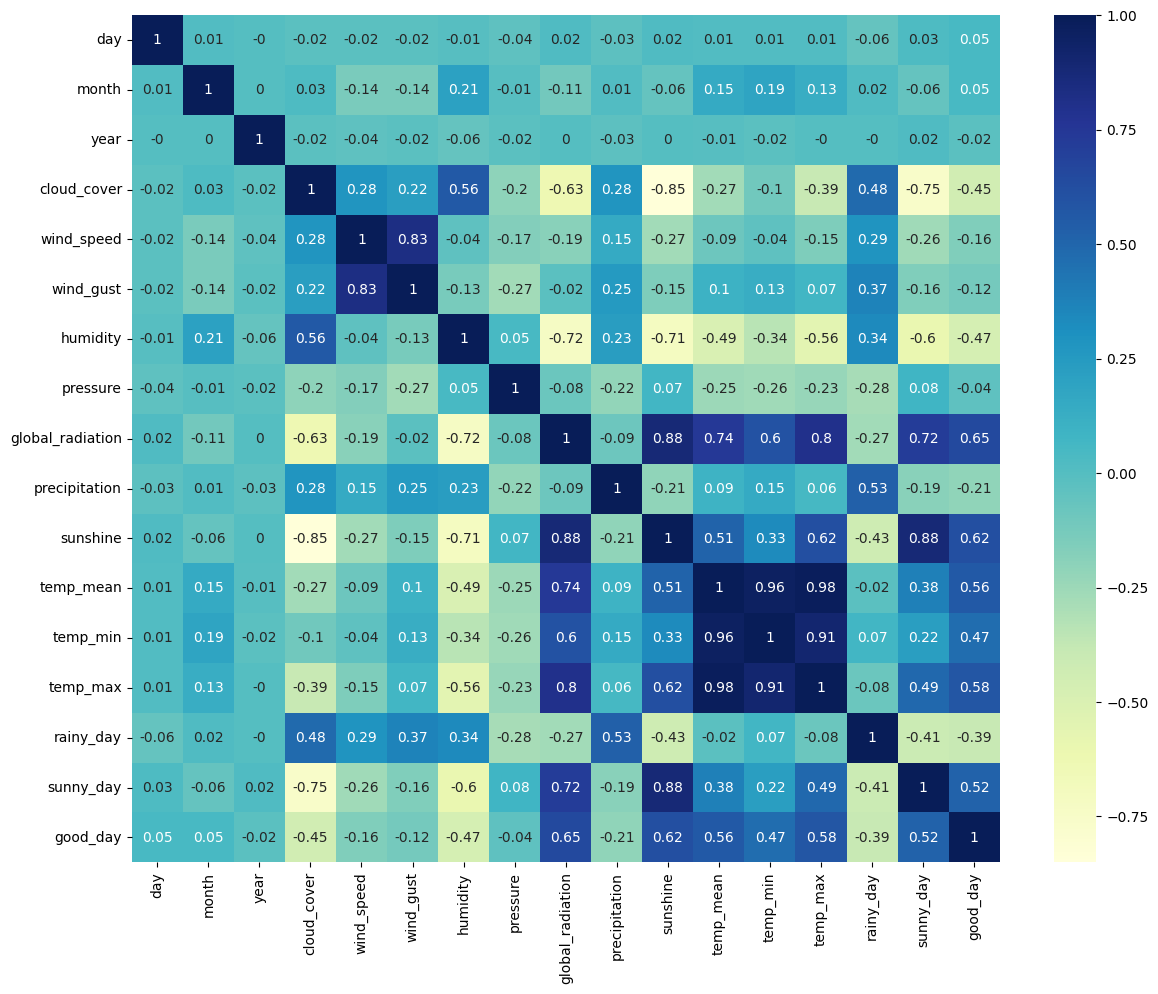

In [33]:
df.corr().style.background_gradient(cmap="Blues")
corr_matrix = np.round(df.corr(), 2)
plt.figure(figsize=(14,11))
sns.heatmap(
    corr_matrix,
    cmap="YlGnBu",
    annot=True,
)

From the correlation study we can see how some features in the dataset are in close contact with each other.
For example:
- Cloud cover with humidity and with precipitation and wind speed
- As cloud cover increases, sunshine and global radiation clearly decrease
- Humidity and precipitation
- as humidity increases, sunshine, global radiation and maximum temperatures decrease
- sunshine and global radiation are highly correlated
- temperatures depend on many different features

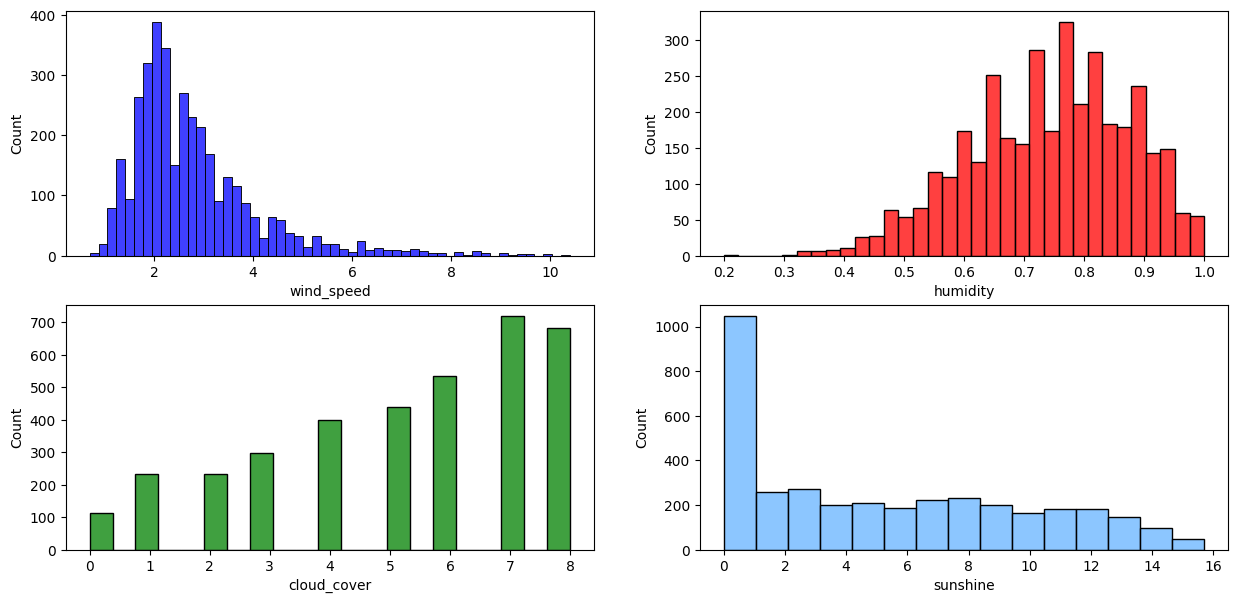

In [34]:
fig, axs = plt.subplots(2,2, figsize=(15,7))
axs = axs.flatten()
sns.histplot(df['wind_speed'],color='blue',ax=axs[0])
sns.histplot(df['humidity'],color='red',ax=axs[1])
sns.histplot(df['cloud_cover'],color='green',ax=axs[2])
sns.histplot(df['sunshine'],color='#66b3ff',ax=axs[3])
plt.show()

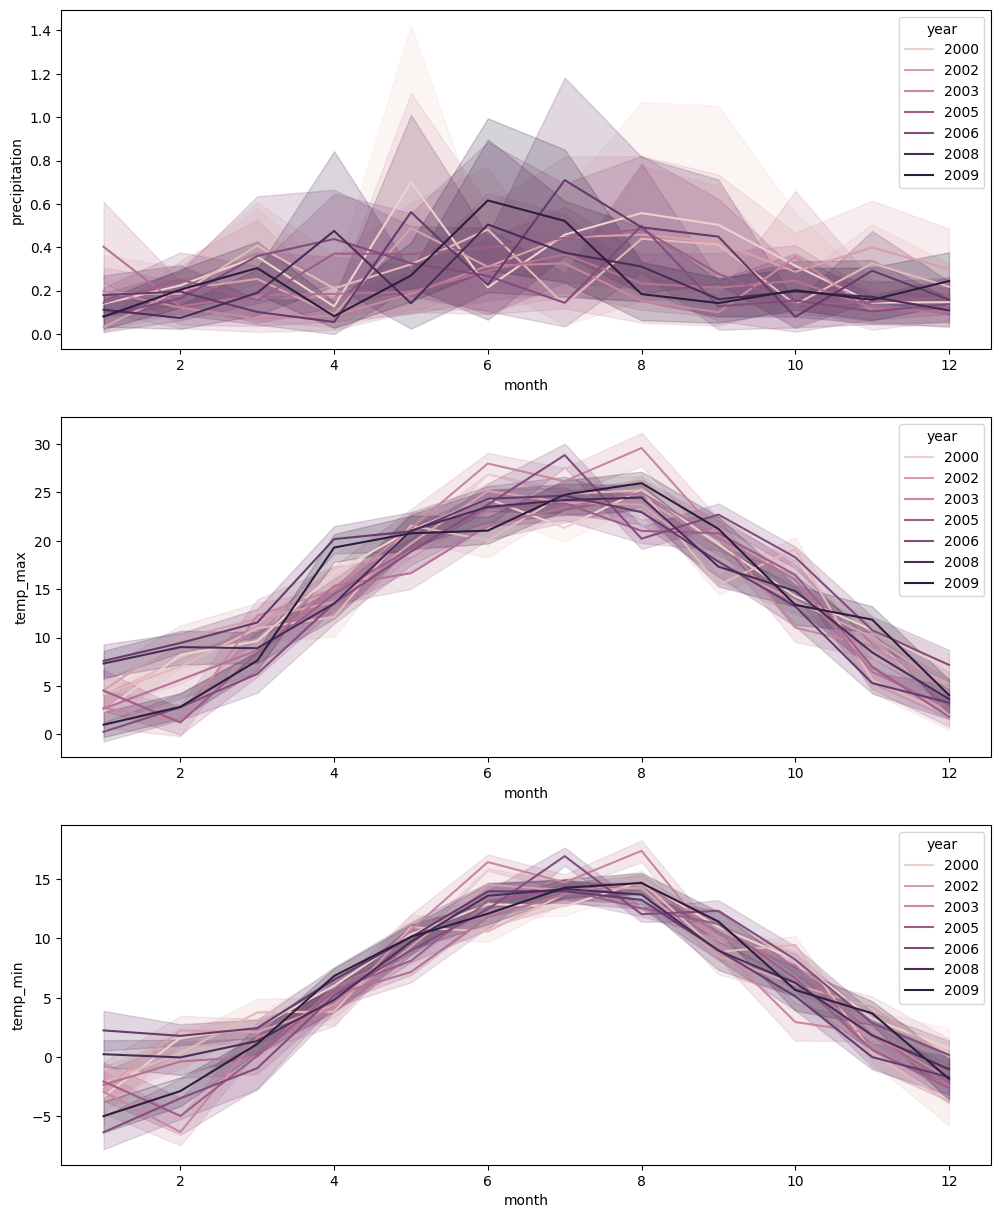

In [35]:
# plotto i valori delle precipitazione per ogni anno in base ai mesi

fig, axs = plt.subplots(3,1, figsize=(12,15))
axs = axs.flatten()
sns.lineplot(data=df, x='month', y='precipitation', hue='year',ax=axs[0])
sns.lineplot(data=df, x='month', y='temp_max', hue='year', ax=axs[1])
sns.lineplot(data=df, x='month', y='temp_min', hue='year', ax=axs[2])
plt.show()



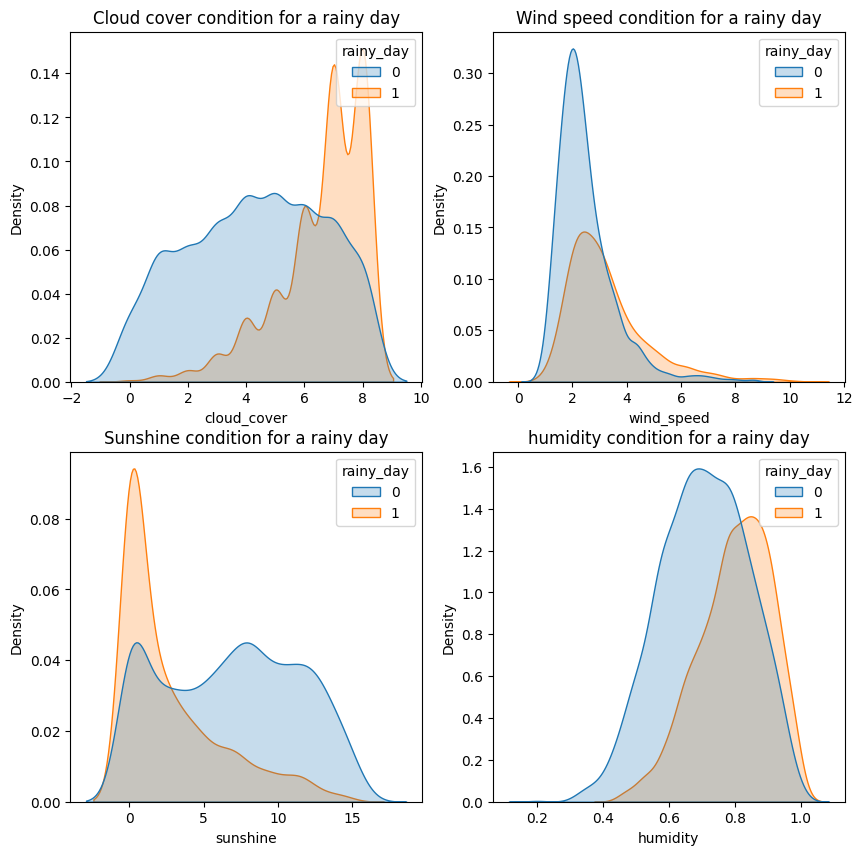

In [36]:
fig, axs = plt.subplots(2,2, figsize = (10,10))
sns.kdeplot(data = df, x='cloud_cover', hue = 'rainy_day', fill = True, ax = axs[0,0])
axs[0,0].set_title('Cloud cover condition for a rainy day')
sns.kdeplot(data = df, x='wind_speed', hue = 'rainy_day', fill = True, ax = axs[0,1])
axs[0,1].set_title('Wind speed condition for a rainy day')
sns.kdeplot(data = df, x='sunshine', hue = 'rainy_day', fill = True, ax = axs[1,0])
axs[1,0].set_title('Sunshine condition for a rainy day')
sns.kdeplot(data = df, x='humidity', hue = 'rainy_day', fill = True, ax = axs[1,1])
axs[1,1].set_title('humidity condition for a rainy day')

plt.show()

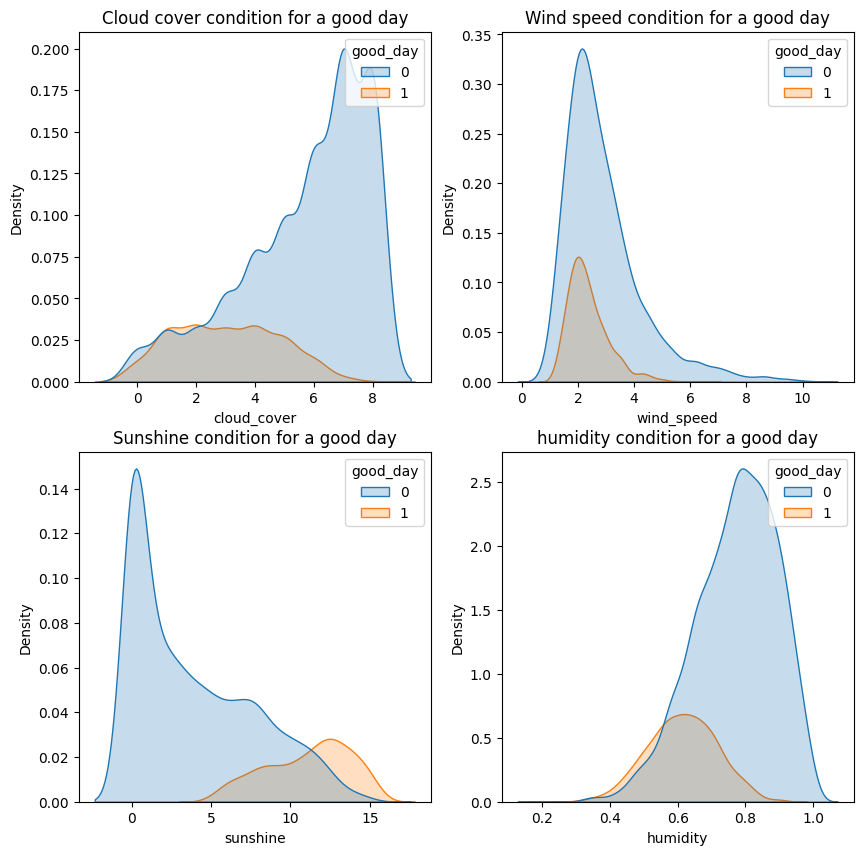

In [37]:
fig, axs = plt.subplots(2,2, figsize = (10,10))
sns.kdeplot(data = df, x='cloud_cover', hue = 'good_day', fill = True, ax = axs[0,0])
axs[0,0].set_title('Cloud cover condition for a good day')
sns.kdeplot(data = df, x='wind_speed', hue = 'good_day', fill = True, ax = axs[0,1])
axs[0,1].set_title('Wind speed condition for a good day')
sns.kdeplot(data = df, x='sunshine', hue = 'good_day', fill = True, ax = axs[1,0])
axs[1,0].set_title('Sunshine condition for a good day')
sns.kdeplot(data = df, x='humidity', hue = 'good_day', fill = True, ax = axs[1,1])
axs[1,1].set_title('humidity condition for a good day')

plt.show()

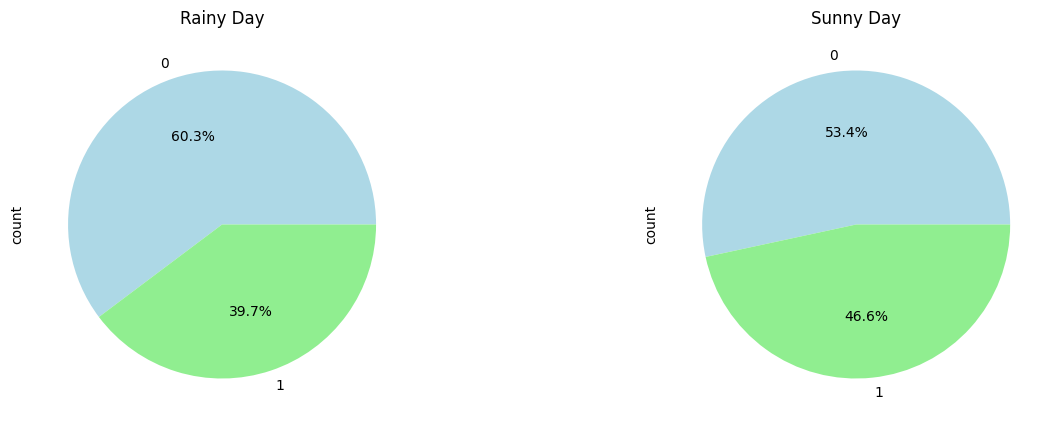

In [38]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
df['rainy_day'].value_counts().plot.pie(autopct='%1.1f%%',ax=axs[0],colors = ['lightblue','lightgreen'])
axs[0].set_title('Rainy Day')
df['sunny_day'].value_counts().plot.pie(autopct='%1.1f%%',ax=axs[1],colors = ['lightblue','lightgreen'])
axs[1].set_title('Sunny Day')
plt.show()

/var/folders/9g/0dtr3lys671b2nb4mvkwxk580000gn/T/ipykernel_6730/3391362982.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='month', y='sunshine', errorbar=None, palette='viridis')


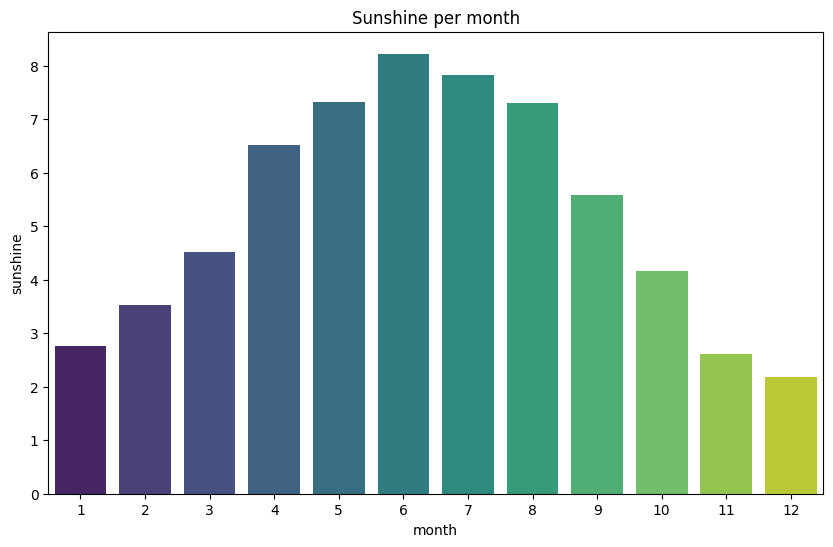

In [39]:
# grafico sui sunshine per ogni mese
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='month', y='sunshine', errorbar=None, palette='viridis')
plt.title('Sunshine per month')
plt.show()


/var/folders/9g/0dtr3lys671b2nb4mvkwxk580000gn/T/ipykernel_6730/4103850213.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='good_day', y='temp_mean', palette='viridis')


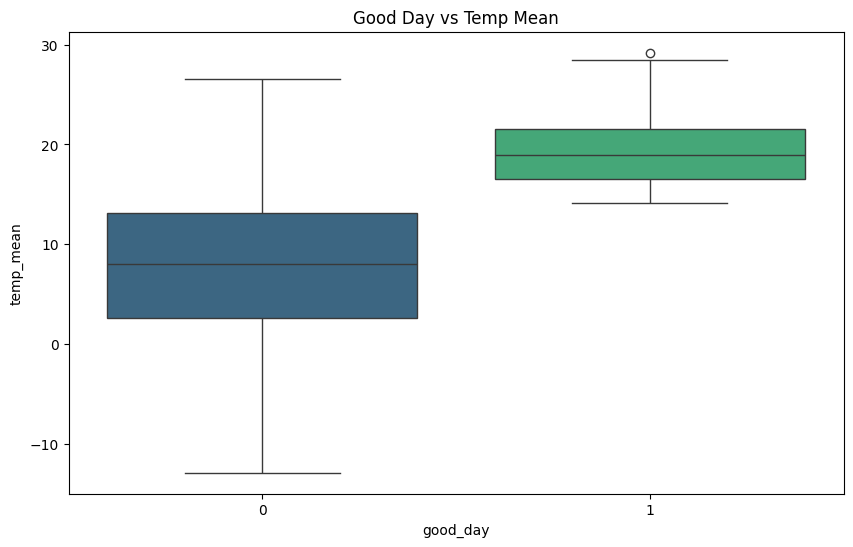

In [40]:
#fai un grafico boxplot con sulle y la temperatura media e sulle x i good_day
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='good_day', y='temp_mean', palette='viridis')
plt.title('Good Day vs Temp Mean')
plt.show()



## MACHINE LEARNING


In [48]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)

/var/folders/9g/0dtr3lys671b2nb4mvkwxk580000gn/T/ipykernel_6730/681481017.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='rainy_day', palette='viridis')


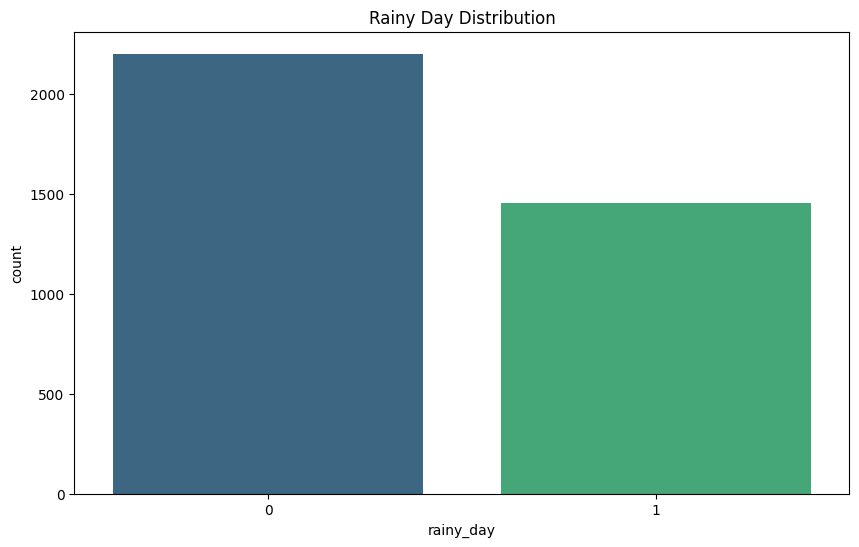

In [49]:
# grafico a barre per vedere la distribuzione dei gioni piovosi e non piovosi
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='rainy_day', palette='viridis')
plt.title('Rainy Day Distribution')
plt.show()


i dati sembrano bilanciati correttamente, non c'è bisogno di fare un sample del dataset

In [50]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

y = df["rainy_day"]
x = df.drop(columns="rainy_day")

scaler = RobustScaler()
norm_X = scaler.fit_transform(x)
norm_X = pd.DataFrame(norm_X, columns = x.columns)
norm_X.head()

,day,month,year,cloud_cover,wind_speed,wind_gust,humidity,pressure,global_radiation,precipitation,sunshine,temp_mean,temp_min,temp_max,sunny_day,good_day
0,-1.000000,-1.0,-0.8,0.666667,0.071429,0.132075,0.842105,1.020202,-0.575758,0.678571,-0.536585,-0.701613,-0.612613,-0.835616,0.0,0.0
1,-0.933333,-1.0,-0.8,0.000000,-0.285714,-0.094340,0.789474,1.505051,-0.296970,-0.035714,0.207317,-0.685484,-0.585586,-0.616438,1.0,0.0
2,-0.866667,-1.0,-0.8,0.333333,-0.285714,-0.339623,0.894737,1.464646,-0.527273,-0.035714,-0.487805,-0.870968,-0.864865,-0.952055,0.0,0.0
3,-0.800000,-1.0,-0.8,0.000000,0.142857,0.566038,0.000000,0.888889,-0.345455,0.107143,0.012195,-0.532258,-0.819820,-0.561644,0.0,0.0
4,-0.733333,-1.0,-0.8,-0.333333,0.571429,0.849057,0.631579,0.767677,-0.539394,-0.035714,-0.512195,-0.411290,-0.180180,-0.513699,0.0,0.0


In [51]:

# Splitting dataset on training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(norm_X,y, test_size = 0.3, random_state = 42)
print('Training set: ' + str(len(X_train)))
print('Testing set: ' + str(len(X_test)))

Training set: 2557
Testing set: 1096


In [52]:
def report(y_test, y_pred):
    print("Results of test set prediction analyzing:")
    print(" ")
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print(" ")
    print("Accuracy of prediction:")
    print(accuracy_score(y_test, y_pred))
    print(" ")
    print("roc-auc score")
    print(roc_auc_score(y_test, y_pred))
    print(" ")

## SVC

In [53]:
from sklearn.svm import SVC

model = SVC(verbose=True, kernel = 'linear', random_state = 0)
model.fit(X_train,y_train)


[LibSVM]..*....*
optimization finished, #iter = 6749
obj = -130.705289, rho = -1.877420
nSV = 184, nBSV = 168
Total nSV = 184


SVC(kernel='linear', random_state=0, verbose=True)

Results of test set prediction analyzing:
 
Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       652
           1       1.00      0.98      0.99       444

    accuracy                           0.99      1096
   macro avg       0.99      0.99      0.99      1096
weighted avg       0.99      0.99      0.99      1096

 
Accuracy of prediction:
0.9908759124087592
 
roc-auc score
0.9887387387387387
 


[Text(0.5, 1.0, 'Confusion Matrix')]

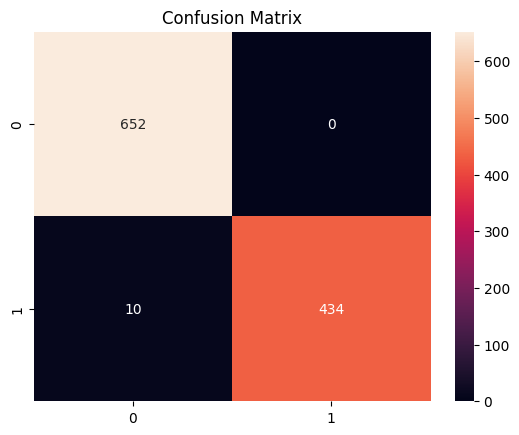

In [57]:
y_predict = model.predict(X_test)
report(y_test, y_predict)
sns.heatmap(confusion_matrix(y_test,y_predict), annot=True, fmt='g').set(title='Confusion Matrix')


In [58]:
print('Model accuracy is: {0:.2f}%'.format(accuracy_score(y_test, y_predict)*100))

Model accuracy is: 99.09%


## LOGISTIC REGRESSION

In [61]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)


LogisticRegression(random_state=42)

Results of test set prediction analyzing:
 
Classification report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       652
           1       1.00      0.96      0.98       444

    accuracy                           0.98      1096
   macro avg       0.99      0.98      0.98      1096
weighted avg       0.98      0.98      0.98      1096

 
Accuracy of prediction:
0.9844890510948905
 
roc-auc score
0.9808558558558558
 


[Text(0.5, 1.0, 'Confusion Matrix')]

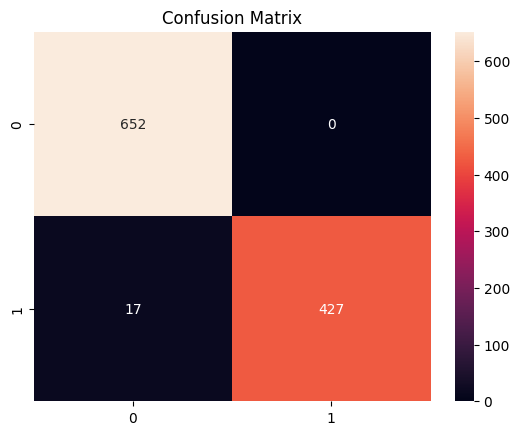

In [62]:
y_predict = model.predict(X_test)
report(y_test, y_predict)
sns.heatmap(confusion_matrix(y_test,y_predict), annot=True, fmt='g').set(title='Confusion Matrix')

In [63]:
print('Model accuracy is: {0:.2f}%'.format(accuracy_score(y_test, y_predict)*100))

Model accuracy is: 98.45%
